In [1]:
#Importing the library
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix , classification_report ,accuracy_score
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# Image Preprocessing

In [1]:
#Data Preprocessing by applying several transformation to create different forms of the same picture to make the model robust.

def preprocess(path, fold):
    for file in os.listdir(path):
        #print(file)
        
        src = cv2.imread(path+"/"+file, cv2.IMREAD_UNCHANGED)
        #image blurring
        blurImg = cv2.blur(src, (20,20))
        #writing the image to the new folder
        cv2.imwrite(path_assignment+fold+"/"+ 'blur_'+file, blurImg)
        
        #adding noise
        row, col, channels = src.shape
        noiseImg = src
        no_of_pix = random.randint(300, 10000)
        #changing random number of pixels to white
        for i in range(no_of_pix):
            y = random.randint(0, row-1)
            x = random.randint(0, col-1)
            noiseImg[y][x] = 255
        #changing random number of pixels to black
        no_of_pix = random.randint(300, 10000)
        for i in range(no_of_pix):
            y = random.randint(0, row-1)
            x = random.randint(0, col-1)
            noiseImg[y][x] = 0
        
        cv2.imwrite(path_assignment+fold + '/noise_'+file, noiseImg)
        
        
        src = cv2.imread(path+"/"+file, cv2.IMREAD_UNCHANGED)
        
        
        #edge detection using Canny edge detection
        edgeImg = cv2.Canny(src, 100, 200)
        
        cv2.imwrite(path_assignment + fold+'/edge_'+file, edgeImg)
        
        #inverting colour of an image
        invertImg = cv2.bitwise_not(src)
        
        cv2.imwrite(path_assignment +fold+ '/invert_'+file, invertImg)

In [ ]:
#Code to save the edge transformed file to the particular folder
path = 'C:/Users/RUPAK/OneDrive/Desktop/Assignment/loopr_vit_dse_assignment_data/'
path_assignment = 'C:/Users/RUPAK/OneDrive/Desktop/Assignment/loopr_vit_dse_assignment_data/'
new_fold_list = ['bishop', 'knight', 'pawn', 'queen', 'rook']
list_resized = ['bishop_resized','knight-resize', 'pawn_resized','queen-resized','rook-resize']
for items, fold in zip(list_resized, new_fold_list):
    preprocess(path+items, fold)

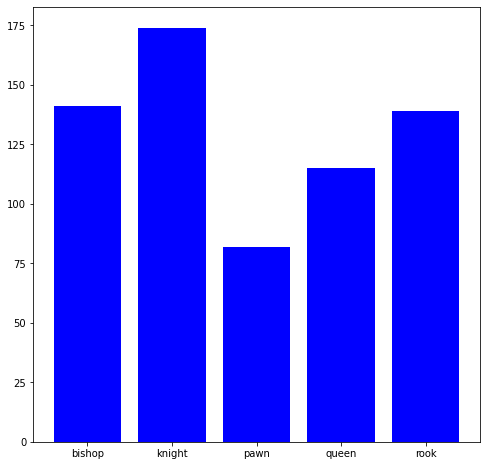

In [5]:
# useful for getting number of output classes
bishop = len(glob('edge_folder/bishop_resized_edge/*'))
knight = len(glob('edge_folder/knight_resize_edge/*'))
pawn = len(glob('edge_folder/pawn_resized_edge/*'))
queen = len(glob('edge_folder/queen_resized_edge/*'))
rook = len(glob('edge_folder/rook_resize_edge/*'))


#Storing the vatiables in a list
chessman = [bishop,knight,pawn,queen,rook]
chessman
cheese_dic = ['bishop','knight','pawn','queen','rook']


#As you can see that knight is having the highest frequency followed by bishop
plt.figure(figsize=(8, 8))
plt.bar(range(len(cheese_dic)), chessman, color="blue")
plt.xticks(range(len(cheese_dic)), ('bishop','knight','pawn','queen','rook'))
plt.show()

# Load the dataset

In [7]:
#Setting the image size which is predefined and mentining the train and valis path
IMAGE_SIZE = [224,224]
train_path = 'tranformed_split_images_upd_1/train'
valid_path = 'tranformed_split_images_upd_1/val'

# Implementation Of VGG16

In [8]:
#Importing the pretrained model
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [9]:
#don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [10]:
# useful for getting number of output classes
folders = glob('tranformed_split_images_upd_1/train/*')

In [11]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [12]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model_vgg16 = Model(inputs=vgg16.input, outputs=prediction)

In [13]:
#Compiling the model
model_vgg16.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('tranformed_split_images_upd_1/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2534 images belonging to 5 classes.


In [16]:
val_set = test_datagen.flow_from_directory('tranformed_split_images_upd_1/val',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 128 images belonging to 5 classes.


In [17]:
# fit the model
# Run the cell. It will take some time to execute
r = model_vgg16.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set),
  
)

<ipython-input-17-a9bb25ee3e13>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model_vgg16.fit_generator(


Epoch 1/20
80/80 [==============================] - 27s 219ms/step - loss: 1.0245 - accuracy: 0.6069 - val_loss: 0.4314 - val_accuracy: 0.8984
Epoch 2/20
80/80 [==============================] - 16s 204ms/step - loss: 0.5311 - accuracy: 0.8031 - val_loss: 0.3641 - val_accuracy: 0.8828
Epoch 3/20
80/80 [==============================] - 20s 254ms/step - loss: 0.4372 - accuracy: 0.8406 - val_loss: 0.2529 - val_accuracy: 0.9531
Epoch 4/20
80/80 [==============================] - 18s 217ms/step - loss: 0.3559 - accuracy: 0.8694 - val_loss: 0.2233 - val_accuracy: 0.9297
Epoch 5/20
80/80 [==============================] - 18s 226ms/step - loss: 0.3277 - accuracy: 0.8840 - val_loss: 0.1873 - val_accuracy: 0.9375
Epoch 6/20
80/80 [==============================] - 18s 229ms/step - loss: 0.3012 - accuracy: 0.8934 - val_loss: 0.2126 - val_accuracy: 0.9453
Epoch 7/20
80/80 [==============================] - 17s 209ms/step - loss: 0.2577 - accuracy: 0.9116 - val_loss: 0.2088 - val_accuracy: 0.9531

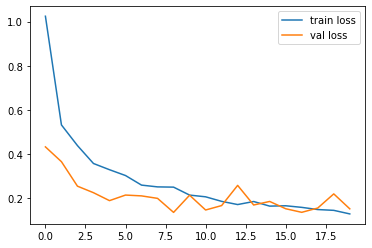

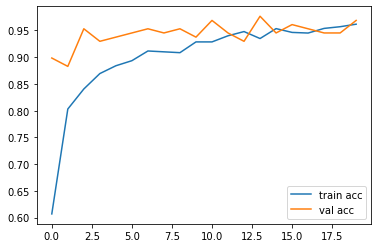

In [18]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()


# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [20]:
from tensorflow.keras.models import load_model

model_vgg16.save('model_vgg16.h5')

In [21]:
model=load_model('model_vgg16.h5')

In [22]:
img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized/00000099_resized.jpg',target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
model.predict(img_data)
a=np.argmax(model.predict(img_data), axis=1)

if a==0:
    print("Bishop")
if a==1:
    print("Knight")
if a==2:
    print("Pawn")
if a==3:
    print("Queen")
if a==4:
    print("Rook")

1/1 [==============================] - 0s 17ms/step
Pawn


In [23]:
test_set_upd = test_datagen.flow_from_directory('tranformed_split_images_upd_1/test',
                                            target_size = (224,224),
                                            class_mode = 'categorical')

Found 70 images belonging to 5 classes.


In [24]:
#Prediction of the test data for each category

bishop_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    bishop_resize.append(a)

knight_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/knight_resize"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/knight_resize/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    knight_resize.append(a)
    
pawn_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/pawn_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/pawn_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    pawn_resize.append(a)
    
    
queen_resized=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/queen_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/queen_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    queen_resized.append(a)
    
rook_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/rook_resize"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/rook_resize/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    rook_resize.append(a)

#Appending all the predicted data in one list
total_test = [2,0,3,0,0,0,0,0,0,0,0,0,2,0,0,1,1,1,1,1,1,1,4,1,1,1,1,4,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4]

1/1 [==============================] - 0s 20ms/step


In [25]:
#Printing the accuracy score
accuracy_score(test_set_upd.classes,total_test)

0.9142857142857143

In [26]:
#Classification report
target_names = ['Bishop','Knight','Pawn','Queen','Rook']
class_report = classification_report(test_set_upd.classes, total_test, target_names=target_names)
print(class_report)

              precision    recall  f1-score   support

      Bishop       0.92      0.80      0.86        15
      Knight       1.00      0.89      0.94        19
        Pawn       0.80      0.89      0.84         9
       Queen       0.92      1.00      0.96        12
        Rook       0.88      1.00      0.94        15

    accuracy                           0.91        70
   macro avg       0.91      0.92      0.91        70
weighted avg       0.92      0.91      0.91        70



# Implementing the VGG19

In [28]:
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [29]:
# don't train existing weights
for layer in vgg19.layers:
    layer.trainable = False

In [30]:
# useful for getting number of output classes
folders = glob('tranformed_split_images_upd_1/train/*')

In [31]:
# our layers - you can add more if you want
x = Flatten()(vgg19.output)

In [32]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model_vgg19 = Model(inputs=vgg19.input, outputs=prediction)

In [33]:
# tell the model what cost and optimization method to use
model_vgg19.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [34]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [35]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('tranformed_split_images_upd_1/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2534 images belonging to 5 classes.


In [36]:
test_set = test_datagen.flow_from_directory('tranformed_split_images_upd_1/val',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 128 images belonging to 5 classes.


In [37]:
# fit the model
# Run the cell. It will take some time to execute
r = model_vgg19.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-37-e8d2d04e41d7>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model_vgg19.fit_generator(


Epoch 1/20
80/80 [==============================] - 36s 437ms/step - loss: 1.2263 - accuracy: 0.5545 - val_loss: 0.5037 - val_accuracy: 0.8359
Epoch 2/20
80/80 [==============================] - 35s 438ms/step - loss: 0.6479 - accuracy: 0.7573 - val_loss: 0.3520 - val_accuracy: 0.8984
Epoch 3/20
80/80 [==============================] - 35s 439ms/step - loss: 0.5753 - accuracy: 0.7873 - val_loss: 0.2605 - val_accuracy: 0.8828
Epoch 4/20
80/80 [==============================] - 37s 461ms/step - loss: 0.4836 - accuracy: 0.8098 - val_loss: 0.2159 - val_accuracy: 0.9219
Epoch 5/20
80/80 [==============================] - 31s 392ms/step - loss: 0.4622 - accuracy: 0.8200 - val_loss: 0.2581 - val_accuracy: 0.9219
Epoch 6/20
80/80 [==============================] - 32s 401ms/step - loss: 0.4694 - accuracy: 0.8197 - val_loss: 0.2152 - val_accuracy: 0.9297
Epoch 7/20
80/80 [==============================] - 32s 403ms/step - loss: 0.4406 - accuracy: 0.8398 - val_loss: 0.2351 - val_accuracy: 0.9375

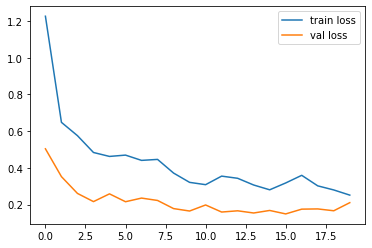

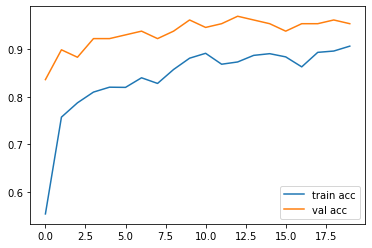

In [38]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [67]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model_vgg19.save('model_vgg19.h5')

In [68]:
model=load_model('model_vgg19.h5')

In [69]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [70]:
img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized/00000099_resized.jpg',target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
model.predict(img_data)
a=np.argmax(model.predict(img_data), axis=1)

if a==0:
    print("Bishop")
if a==1:
    print("Knight")
if a==2:
    print("Pawn")
if a==3:
    print("Queen")
if a==4:
    print("Rook")

1/1 [==============================] - 0s 19ms/step
Queen


In [71]:
bishop_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    bishop_resize.append(a)

knight_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/knight_resize"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/knight_resize/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    knight_resize.append(a)
    
pawn_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/pawn_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/pawn_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    pawn_resize.append(a)
    
    
queen_resized=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/queen_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/queen_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    queen_resized.append(a)
    
rook_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/rook_resize"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/rook_resize/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    rook_resize.append(a)

1/1 [==============================] - 0s 19ms/step


In [78]:
rook_resize

[array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64)]

In [79]:
#prediction of the test set
total_test = [2,0,3,0,0,0,0,0,2,0,0,0,3,3,0,1,1,1,1,1,1,1,2,1,1,1,1,2,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4]

len(total_test)

70

In [80]:
#Printing the accuracy score
accuracy_score(test_set_upd.classes,total_test)

0.8857142857142857

In [81]:
#Classification report
target_names = ['Bishop','Knight','Pawn','Queen','Rook']
class_report = classification_report(test_set_upd.classes, total_test, target_names=target_names)
print(class_report)

              precision    recall  f1-score   support

      Bishop       0.91      0.67      0.77        15
      Knight       1.00      0.89      0.94        19
        Pawn       0.67      0.89      0.76         9
       Queen       0.80      1.00      0.89        12
        Rook       1.00      1.00      1.00        15

    accuracy                           0.89        70
   macro avg       0.88      0.89      0.87        70
weighted avg       0.90      0.89      0.89        70



# Implementing the RESNET

In [199]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [200]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [201]:
# useful for getting number of output classes
folders = glob('tranformed_split_images_upd_1/train/*')

In [202]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [203]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model_resnet = Model(inputs=resnet.input, outputs=prediction)

In [204]:
# tell the model what cost and optimization method to use
model_resnet.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [205]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [206]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('tranformed_split_images_upd_1/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2534 images belonging to 5 classes.


In [207]:
test_set = test_datagen.flow_from_directory('tranformed_split_images_upd_1/val',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 128 images belonging to 5 classes.


In [208]:
# fit the model
# Run the cell. It will take some time to execute
r = model_resnet.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-208-8c3bc1ed5aa0>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model_resnet.fit_generator(


Epoch 1/20
80/80 [==============================] - 26s 262ms/step - loss: 3.2628 - accuracy: 0.3425 - val_loss: 1.9148 - val_accuracy: 0.4609
Epoch 2/20
80/80 [==============================] - 15s 189ms/step - loss: 1.4758 - accuracy: 0.4799 - val_loss: 1.1953 - val_accuracy: 0.5078
Epoch 3/20
80/80 [==============================] - 27s 332ms/step - loss: 1.2405 - accuracy: 0.5430 - val_loss: 1.0445 - val_accuracy: 0.6016
Epoch 4/20
80/80 [==============================] - 28s 351ms/step - loss: 1.2180 - accuracy: 0.5627 - val_loss: 1.0979 - val_accuracy: 0.5859
Epoch 5/20
80/80 [==============================] - 14s 178ms/step - loss: 1.4058 - accuracy: 0.5564 - val_loss: 1.6165 - val_accuracy: 0.5156
Epoch 6/20
80/80 [==============================] - 14s 179ms/step - loss: 1.2164 - accuracy: 0.5908 - val_loss: 1.4037 - val_accuracy: 0.5547
Epoch 7/20
80/80 [==============================] - 15s 181ms/step - loss: 0.9697 - accuracy: 0.6433 - val_loss: 0.9053 - val_accuracy: 0.6562

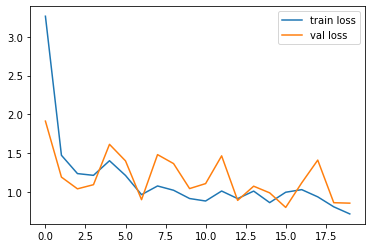

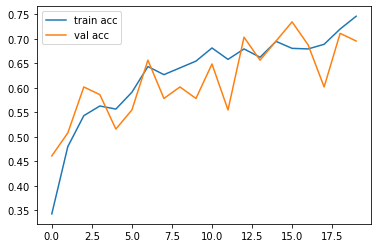

In [209]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()


# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [210]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model_resnet.save('model_resnet.h5')

In [211]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [212]:
model=load_model('model_resnet.h5')

In [213]:
bishop_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    bishop_resize.append(a)

knight_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/knight_resize"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/knight_resize/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    knight_resize.append(a)
    
pawn_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/pawn_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/pawn_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    pawn_resize.append(a)
    
    
queen_resized=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/queen_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/queen_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    queen_resized.append(a)
    
rook_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/rook_resize"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/rook_resize/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    rook_resize.append(a)

1/1 [==============================] - 0s 29ms/step


In [218]:
rook_resize

[array([4], dtype=int64),
 array([4], dtype=int64),
 array([3], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([4], dtype=int64),
 array([0], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([4], dtype=int64),
 array([0], dtype=int64)]

In [219]:
total_test = [2,0,2,2,0,0,0,0,0,0,0,0,1,2,0, 1,1,1,1,1,1,1,1,1,1,1,4,1,1,1,1,1,1,0, 2,2,2,2,2,0,2,2,2, 0,4,0,0,3,0,0,1,0,0,0,0, 4,4,3,0,1,4,0,4,4,2,0,1,1,4,0]
len(total_test)

70

In [220]:
#Printing the accuracy score
accuracy_score(test_set_upd.classes,total_test)

0.6

In [221]:
#Classification report
target_names = ['Bishop','Knight','Pawn','Queen','Rook']
class_report = classification_report(test_set_upd.classes, total_test, target_names=target_names)
print(class_report)

              precision    recall  f1-score   support

      Bishop       0.40      0.67      0.50        15
      Knight       0.77      0.89      0.83        19
        Pawn       0.62      0.89      0.73         9
       Queen       0.50      0.08      0.14        12
        Rook       0.75      0.40      0.52        15

    accuracy                           0.60        70
   macro avg       0.61      0.59      0.54        70
weighted avg       0.62      0.60      0.56        70



# Implementation of Inception

In [166]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [167]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [168]:
# useful for getting number of output classes
folders = glob('tranformed_split_images_upd_1/train/*')

In [169]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [170]:
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model_inception = Model(inputs=inception.input, outputs=prediction)

In [171]:
# tell the model what cost and optimization method to use
model_inception.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [182]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [183]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('tranformed_split_images_upd_1/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2534 images belonging to 5 classes.


In [184]:
test_set = test_datagen.flow_from_directory('tranformed_split_images_upd_1/val',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 128 images belonging to 5 classes.


In [185]:
# fit the model
# Run the cell. It will take some time to execute
r = model_inception.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
)

Epoch 1/20


<ipython-input-185-5437ff5875b1>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model_inception.fit_generator(


80/80 [==============================] - 10s 126ms/step - loss: 0.9087 - accuracy: 0.8311 - val_loss: 1.1242 - val_accuracy: 0.8438
Epoch 2/20
80/80 [==============================] - 14s 175ms/step - loss: 0.4763 - accuracy: 0.8836 - val_loss: 1.0253 - val_accuracy: 0.8438
Epoch 3/20
80/80 [==============================] - 12s 144ms/step - loss: 0.7402 - accuracy: 0.8733 - val_loss: 0.8490 - val_accuracy: 0.8750
Epoch 4/20
80/80 [==============================] - 11s 133ms/step - loss: 0.3675 - accuracy: 0.9187 - val_loss: 1.0976 - val_accuracy: 0.9297
Epoch 5/20
80/80 [==============================] - 11s 135ms/step - loss: 0.3210 - accuracy: 0.9313 - val_loss: 1.0702 - val_accuracy: 0.8516
Epoch 6/20
80/80 [==============================] - 11s 139ms/step - loss: 0.2678 - accuracy: 0.9455 - val_loss: 0.8591 - val_accuracy: 0.9141
Epoch 7/20
80/80 [==============================] - 11s 138ms/step - loss: 0.2333 - accuracy: 0.9566 - val_loss: 1.5329 - val_accuracy: 0.9062
Epoch 8/20

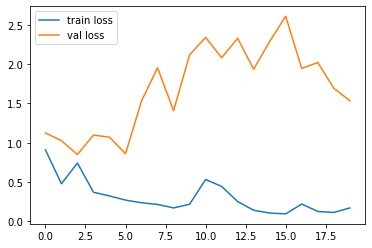

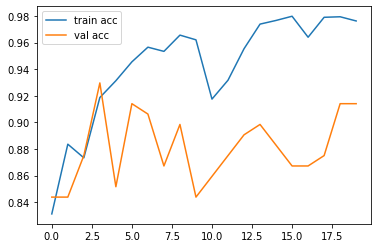

In [186]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()


# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [187]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model_inception.save('model_inception.h5')

In [188]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [189]:
model=load_model('model_inception.h5')

In [190]:
bishop_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    bishop_resize.append(a)

knight_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/knight_resize"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/knight_resize/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    knight_resize.append(a)
    
pawn_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/pawn_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/pawn_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    pawn_resize.append(a)
    
    
queen_resized=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/queen_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/queen_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    queen_resized.append(a)
    
rook_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/rook_resize"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/rook_resize/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    rook_resize.append(a)

1/1 [==============================] - 0s 31ms/step


In [195]:
rook_resize

[array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([3], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([3], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([4], dtype=int64),
 array([3], dtype=int64),
 array([4], dtype=int64)]

In [196]:
total_test = [0,0,0,0,0,0,0,0,2,0,3,0,0,0,0, 1,1,1,1,1,1,1,3,1,1,1,1,3,1,1,1,1,1,1, 2,2,2,2,2,3,0,2,0, 3,3,3,3,3,3,3,3,0,3,3, 4,4,4,3,4,4,4,3,4,4,4,4,4,4,3,4]

len(total_test)

70

In [197]:
#Printing the accuracy score
accuracy_score(test_set_upd.classes,total_test)

0.8285714285714286

In [198]:
#Classification report
target_names = ['Bishop','Knight','Pawn','Queen','Rook']
class_report = classification_report(test_set_upd.classes, total_test, target_names=target_names)
print(class_report)

              precision    recall  f1-score   support

      Bishop       0.81      0.87      0.84        15
      Knight       1.00      0.89      0.94        19
        Pawn       0.86      0.67      0.75         9
       Queen       0.59      0.83      0.69        12
        Rook       0.92      0.80      0.86        15

    accuracy                           0.83        70
   macro avg       0.84      0.81      0.82        70
weighted avg       0.85      0.83      0.83        70



# Implementation in ANN

In [144]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
    ])

In [145]:
folders = glob('tranformed_split_images_upd_1/train/*')

In [146]:
# our layers - you can add more if you want
x = Flatten()(model.output)

In [147]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model_ann = Model(inputs=model.input, outputs=prediction)

In [148]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [149]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('tranformed_split_images_upd_1/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2534 images belonging to 5 classes.


In [150]:
test_set = test_datagen.flow_from_directory('tranformed_split_images_upd_1/val',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 128 images belonging to 5 classes.


In [151]:
model_ann.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [152]:
r = model_ann.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
)

Epoch 1/20
80/80 [==============================] - 5s 63ms/step - loss: 1.6562 - accuracy: 0.2092 - val_loss: 1.6457 - val_accuracy: 0.2109
Epoch 2/20
80/80 [==============================] - 5s 63ms/step - loss: 1.6268 - accuracy: 0.2151 - val_loss: 1.6169 - val_accuracy: 0.2109
Epoch 3/20
80/80 [==============================] - 5s 65ms/step - loss: 1.6054 - accuracy: 0.2163 - val_loss: 1.6000 - val_accuracy: 0.2109
Epoch 4/20
80/80 [==============================] - 4s 53ms/step - loss: 1.5934 - accuracy: 0.2163 - val_loss: 1.5911 - val_accuracy: 0.2109
Epoch 5/20
80/80 [==============================] - 4s 50ms/step - loss: 1.5870 - accuracy: 0.2352 - val_loss: 1.5867 - val_accuracy: 0.2656
Epoch 6/20
80/80 [==============================] - 4s 47ms/step - loss: 1.5841 - accuracy: 0.2672 - val_loss: 1.5838 - val_accuracy: 0.2656
Epoch 7/20
80/80 [==============================] - 5s 60ms/step - loss: 1.5823 - accuracy: 0.2668 - val_loss: 1.5827 - val_accuracy: 0.2656
Epoch 8/20
80

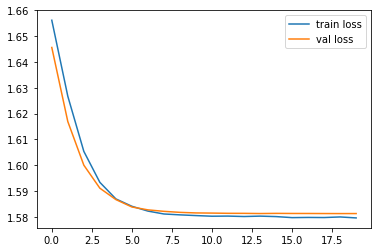

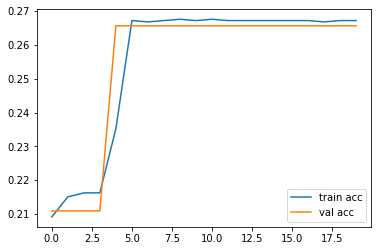

In [153]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()


# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [154]:
from tensorflow.keras.models import load_model

model_ann.save('model_ann.h5')

In [155]:
model=load_model('model_ann.h5')

In [156]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [157]:
bishop_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/bishop_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    bishop_resize.append(a)

knight_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/knight_resize"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/knight_resize/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    knight_resize.append(a)
    
pawn_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/pawn_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/pawn_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    pawn_resize.append(a)
    
    
queen_resized=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/queen_resized"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/queen_resized/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    queen_resized.append(a)
    
rook_resize=[]
for files in os.listdir("C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/rook_resize"):
    #print(files)
    img=image.load_img('C:/Users/RUPAK/OneDrive/Desktop/Assignment/tranformed_split_images_upd_1/test/rook_resize/'+files,target_size=(224,224))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    model.predict(img_data)
    a=np.argmax(model.predict(img_data), axis=1)
    rook_resize.append(a)

1/1 [==============================] - 0s 28ms/step


In [162]:
rook_resize

[array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64)]

In [163]:
total_test = [1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0, 1,1,1,1,1,0,1,1,1,1,1,1, 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

len(total_test)

70

In [164]:
#Printing the accuracy score
accuracy_score(test_set_upd.classes,total_test)

0.22857142857142856

In [165]:
#Classification report
target_names = ['Bishop','Knight','Pawn','Queen','Rook']
class_report = classification_report(test_set_upd.classes, total_test, target_names=target_names)
print(class_report)

              precision    recall  f1-score   support

      Bishop       0.14      0.07      0.09        15
      Knight       0.24      0.79      0.37        19
        Pawn       0.00      0.00      0.00         9
       Queen       0.00      0.00      0.00        12
        Rook       0.00      0.00      0.00        15

    accuracy                           0.23        70
   macro avg       0.08      0.17      0.09        70
weighted avg       0.10      0.23      0.12        70



C:\Users\RUPAK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RUPAK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RUPAK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Conclusion :
    As per the comparison VGG16 stands out to be the best model among all for this data with a train and test accuracy of more than 90 percent.
    Followed by that VGG19 and inception which is coming around 80 percent.